In [1]:

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# process load time data
systems = ['PyTorch', 'DLCache']
compute_time = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
batch_size = [512, 1024, 2048]
repeats = 3
data = []

for s in systems:
    for r in range(repeats):
        for b in batch_size:
            for c in compute_time:
                try:
                    dir = "{}/run{}/{}/{}".format(s, r, c, b)
                    load_time = np.sum(np.load('{}/load_time.npy'.format(dir)))
                    throughput = b * 100 / load_time
                    if os.path.exists('{}/train_cache_usage.npy'.format(dir)):
                        avg_cache_usage = np.load('{}/train_cache_usage.npy'.format(dir))
                        avg_cache_usage = np.mean(avg_cache_usage, dtype=int)
                        cache_hits = 0
                        for ch in glob.glob("{}/cache_hits*".format(dir)):
                            cache_hits += np.load(ch)
                        cache_hit_rate = cache_hits / (b * 100)
                        if s == 'DLCache':
                            opt_worker_num = np.load('{}/worker_num_hist.npy'.format(dir))[-1]
                        else:
                            opt_worker_num = 0
                    else:
                        avg_cache_usage = 0
                        cache_hit_rate = 0
                        opt_worker_num = 0

                    if s in ['PyTorch', 'DLCache']:
                        memory_usage = np.mean(np.load('{}/memory_usage.npy'.format(dir))[20:])
                    else:
                        memory_usage = 0
                    data.append([s, c, b, throughput, load_time, avg_cache_usage, cache_hit_rate, memory_usage, opt_worker_num])
                except Exception as ex:
                    print(ex)

data = pd.DataFrame(data, columns=['Method', 'compute_time', 'batch_size', 'throughput', 'load_time', 'avg_cache_usage', 'cache_hit_rate', 'memory', 'opt_num_worker'])
data.sort_values(by='compute_time', inplace=True)
data.to_csv('data.csv', index=False)

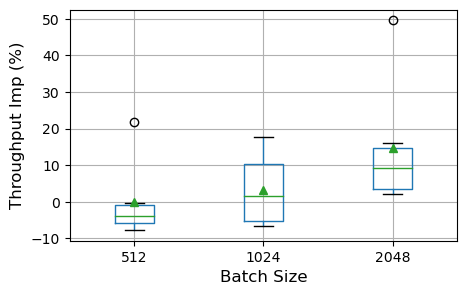

In [2]:
imp = {}
for n1, g1 in data.groupby('batch_size'):
    tmp = {}
    for n2, g2 in g1.groupby('Method'):
        tmp[n2] = {}
        for n3, g3 in g2.groupby("compute_time"):
            tmp[n2][n3] = g3.mean()['throughput']
    tmp = pd.DataFrame(tmp)
    imp[n1] = 100 * (tmp['DLCache'] - tmp['PyTorch']) / tmp['PyTorch']

imp = pd.DataFrame(imp)
imp.to_csv('throughput_imp.csv', index=True, index_label='compute_time')

bplot = imp.boxplot(showmeans=True, figsize=(5, 3))
bplot.set_ylabel('Throughput Imp (%)', fontsize=12)
bplot.set_xlabel('Batch Size', fontsize=12)
plt.savefig("./images/throughput_imp.png", dpi=300, bbox_inches="tight")
plt.show()

In [4]:
imp

,512,1024,2048
0.5,21.787445,5.712072,2.455537
1.0,-5.838943,17.612138,7.233659
1.5,-0.412299,12.056234,11.336115
2.0,-5.546235,-6.179078,2.262956
2.5,-2.360203,-6.665023,49.621868
3.0,-7.741759,-2.610512,15.963892


In [ ]:
imp.mean()

512     -0.018666
1024     3.320972
2048    14.812338
dtype: float64

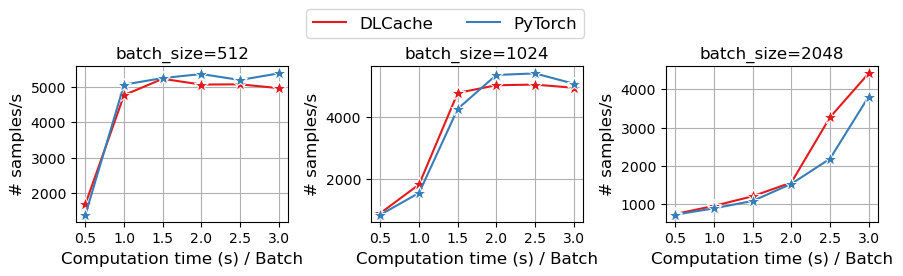

In [ ]:
fig, axes = plt.subplots(1, len(batch_size), figsize=(3*len(batch_size), 2.5))

markers = ['.', '*']
for j, b in enumerate(batch_size):
    slice = data[data['batch_size']==b].sort_values(by='compute_time')
    compute_time_ticks = []
    for ct in slice['compute_time']:
        compute_time_ticks.append(compute_time.index(ct))
    slice['compute_time'] = compute_time_ticks
    # ax = sns.boxplot(ax=axes[j], data=slice, x='compute_time', y='load_time', hue='Method', hue_order=['DLCache', 'PyTorch'])
    ax = sns.lineplot(ax=axes[j], data=slice, x='compute_time', y='throughput', hue='Method', hue_order=['DLCache', 'PyTorch'], 
                        marker='*', markersize=10, palette = "Set1", ci=None)
    ax.grid(True)
    ax.get_legend().remove()
    ax.set_xticks(np.arange(len(compute_time)))
    ax.set_xticklabels(compute_time)
    ax.set_xlabel('Computation time (s) / Batch', fontsize=12)
    ax.set_ylabel('# samples/s', fontsize=12)
    ax.set_title('batch_size={}'.format(b), fontsize=12)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.12), fontsize=12)
plt.tight_layout()
plt.savefig("./images/throughput.png", dpi=300, bbox_inches='tight')
plt.show()

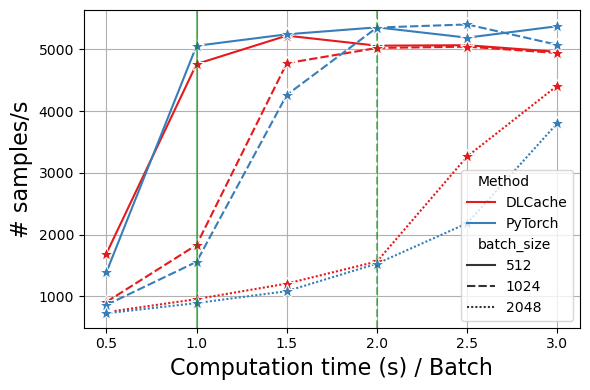

In [ ]:
fig = plt.figure(figsize=(6, 4))

markers = ['.', '*']

slice = data.sort_values(by='compute_time')
compute_time_ticks = []
for ct in slice['compute_time']:
    compute_time_ticks.append(compute_time.index(ct))
slice['compute_time'] = compute_time_ticks
ax = sns.lineplot(data=slice, x='compute_time', y='throughput', hue='Method', hue_order=['DLCache', 'PyTorch'], style='batch_size',
                    marker='*', markersize=10, ci=None, palette = "Set1")
ax.grid(True)
ax.set_xticks(np.arange(len(compute_time)))
ax.set_xticklabels(compute_time)
ax.set_xlabel('Computation time (s) / Batch', fontsize=16)
ax.set_ylabel('# samples/s', fontsize=16)
# ax.get_legend().remove()
ax.axvline(x=1.0, c='g', alpha=0.5)
ax.axvline(x=3.0, c='g', alpha=0.5, linestyle='--')


# plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("./images/throughput.png", dpi=300, bbox_inches='tight')
plt.show()

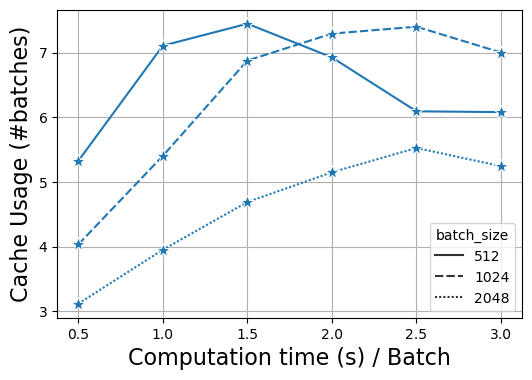

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(6, 4))

slice = data[(data['Method']=='DLCache')].sort_values(by='compute_time')
compute_time_ticks = []
for ct in slice['compute_time']:
    compute_time_ticks.append(compute_time.index(ct))
slice['compute_time'] = compute_time_ticks
slice['cache_hit_rate'] *= 100.0
slice['cache_usage'] = slice['avg_cache_usage'] / slice['batch_size']
# ax = sns.barplot(x='compute_time', y='cache_usage' , data=slice, hue='batch_size', ci=None, dodge=False, palette = "Set1", alpha=0.8)
ax = sns.lineplot(x='compute_time', y='cache_usage' , data=slice, style='batch_size', ci=None, palette = "Set1", marker='*', markersize=10)
# ax2 = ax.twinx()
# sns.lineplot(ax=ax2, x='compute_time', y='cache_hit_rate', data=slice, style='batch_size', marker= 'o', palette = "Set1", markersize=10, ci=None)

# ax.legend(handles=[mpatches.Rectangle((0, 0), 1, 1, fc='black', label='Cache Usage (#batches)'), 
#                   Line2D([], [], marker='o', color="black", label='Cache Hit Rate (%)')],
#           loc='lower right')

# ax.get_legend().remove()
ax.grid(True)
ax.set_xticks(np.arange(len(compute_time)))
ax.set_xticklabels(compute_time)
ax.set_xlabel('Computation time (s) / Batch', fontsize=16)
ax.set_ylabel('Cache Usage (#batches)', fontsize=16)
# ax2.set_ylabel('Cache Hit Rate (%)', fontsize=16)
plt.savefig("./images/cache.png", dpi=300, bbox_inches='tight')
plt.show()

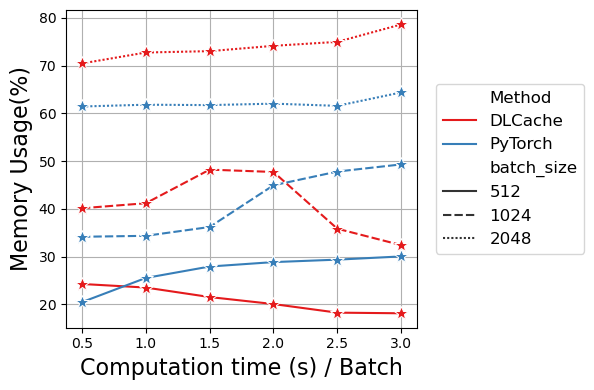

In [ ]:
fig = plt.figure(figsize=(7, 4))

markers = ['.', '*']
slice = data.sort_values(by='compute_time')
compute_time_ticks = []
for ct in slice['compute_time']:
    compute_time_ticks.append(compute_time.index(ct))
slice['compute_time'] = compute_time_ticks
ax = sns.lineplot(data=slice, x='compute_time', y='memory', hue='Method', style='batch_size', hue_order=['DLCache', 'PyTorch'], 
                    marker='*', markersize=10, palette = "Set1", ci=None)

ax.grid(True)
ax.set_xticks(np.arange(len(compute_time)))
ax.set_xticklabels(compute_time)
ax.set_xlabel('Computation time (s) / Batch', fontsize=16)
ax.set_ylabel('Memory Usage(%)', fontsize=16)
ax.get_legend().remove()

plt.legend(fontsize=12, loc='center right', ncol=1, bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.savefig("./images/memory_usage.png", dpi=300, bbox_inches='tight')
plt.show()

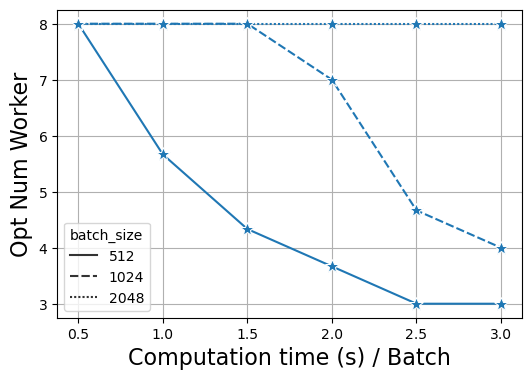

In [ ]:
fig = plt.figure(figsize=(6, 4))

slice = data[(data['Method']=='DLCache')].sort_values(by='compute_time')
compute_time_ticks = []
for ct in slice['compute_time']:
    compute_time_ticks.append(compute_time.index(ct))
slice['compute_time'] = compute_time_ticks
ax = sns.lineplot(x='compute_time', y='opt_num_worker', data=slice, style='batch_size', 
                  marker= '*', markersize=10, palette = "Set1", ci=None)

ax.grid(True)
ax.set_xticks(np.arange(len(compute_time)))
ax.set_xticklabels(compute_time)
# ax.get_legend().remove()

# plt.legend(fontsize=12, loc='center right', ncol=1, bbox_to_anchor=(1.5, 0.5))
ax.set_xlabel('Computation time (s) / Batch', fontsize=16)
ax.set_ylabel('Opt Num Worker', fontsize=16)
plt.savefig("./images/num_workers.png", dpi=300, bbox_inches='tight')
plt.show()